Car License Plate Reader - Overview
1. Input Image
2. Grayscale Image
3. Binarize Image
4. Plate Localization
5. Character Segmentation
6. Character Recognition

In [1]:
# Author: Luke O'Shea Scanlan, Panagiotis Bampilis
# Module: Image Processing 2023-2024
# Group Project

import re
import cv2
import easyocr
import numpy as np
from matplotlib import pyplot as plt

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


License plate found on this image is:  I61-0-16396


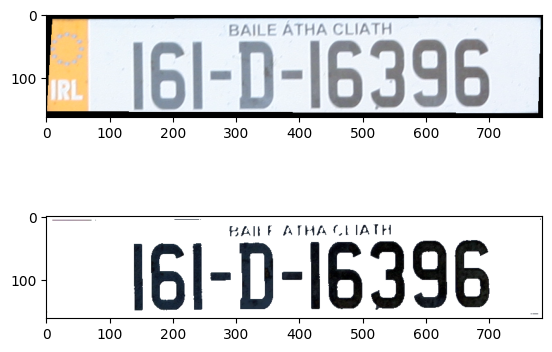

In [2]:
"""
This project aims to give the user the ability to input any sample images of car license plates
and return the results as a text output.

The product is capable of recognising car license plates rotated, as well as a certain amount of blurriness.
"""

# Input Image
# I = cv2.imread("Sample Inputs/personal_three.jpg")
I = cv2.imread("Sample Inputs/personal_two.jpg")
# I = cv2.imread("Sample Inputs/personal.jpg")
# I = cv2.imread("Sample Inputs/ambulance.jpg")
# I = cv2.imread("Sample Inputs/gardai_cars.jpg")

### Image Threshold ###

# HS(V) Image to be used for turning into binary image 
V = cv2.cvtColor(I, cv2.COLOR_BGR2HSV)[:,:,2]

# Binarize Image
B = cv2.adaptiveThreshold(V, maxValue = 255, adaptiveMethod = cv2.ADAPTIVE_THRESH_MEAN_C, thresholdType = cv2.THRESH_BINARY, blockSize = 7, C = 0)


### Plate Localization ###

blank = np.zeros_like(I)
cropping_coord = []

# Contours used to find edges with rectangle areas in the image
contours, hierarchy = cv2.findContours(image=B, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
image_copy = cv2.cvtColor(I.copy(), cv2.COLOR_BGR2RGB)

# Finding every rectangle shape with four corners in the image by setting the length of the license plates 4 times longer its height
for contour in contours:
 
    epsilon = 0.04 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    
    if len(approx) == 4: 
        ct_area = cv2.contourArea(contour)
        
        width_one = int(np.linalg.norm(approx[0][0] - approx[1][0]))
        height_one = int(np.linalg.norm(approx[1][0] - approx[2][0]))
        
        width_two = int(np.linalg.norm(approx[2][0] - approx[3][0]))
        height_two = int(np.linalg.norm(approx[3][0] - approx[0][0]))
        
        if height_one > width_one:
            height_one, width_one, height_two, width_two = width_one, height_one, width_two, height_two
        
        ck_similar_heights = abs(height_one - height_two) < 45
        ck_height_width_ratio = (height_one * 3) < width_one
        ck_similar_area_lower = ct_area > (height_one*width_one/1.1)
        ck_similar_area_upper = ct_area < (height_one*width_one*1.1) 
        ck_too_small = ct_area > 500

        # Ignoring any small rectangle areas
        total_checks = ck_too_small and ck_similar_area_lower and ck_similar_area_upper and ck_similar_heights and ck_height_width_ratio
        
        if total_checks:
            cv2.drawContours(blank, [approx], 0, (255, 255, 255), -1)
            cropping_coord.append((cv2.boundingRect(contour)))


# Plate Cropping
if len(cropping_coord) > 0:
    reg = cv2.bitwise_and(I, I, mask=cv2.cvtColor(blank, cv2.COLOR_BGR2GRAY))
    x, y, w, h = cropping_coord[0]
    CROP = reg[y:y+h,x:x+w]


### Plate number Enhancement ###

# Converting image to gray scale
gray = cv2.cvtColor(CROP, cv2.COLOR_BGR2GRAY)
value = cv2.cvtColor(CROP, cv2.COLOR_BGR2HSV)[:,:,2]

# Adaptive Inverted Threshold
_, threshold = cv2.threshold(value, 190, 255, cv2.THRESH_BINARY_INV)
# threshold = cv2.adaptiveThreshold(V, maxValue = 255, adaptiveMethod = cv2.ADAPTIVE_THRESH_MEAN_C, thresholdType = cv2.THRESH_BINARY_INV, blockSize = 7, C = 1)

# Creating Region of Interest to mask out the plate number from the license plates
ROI = cv2.bitwise_and(CROP, CROP, mask=threshold)
ROI_INV = cv2.bitwise_not(ROI)

# Creating empty canvas to use as a white background
canvas = np.zeros(CROP.shape, np.uint8)
canvas.fill(255)

# Cropping out the plate number by using the mask 
cropped_plates = cv2.subtract(CROP, ROI_INV)
cropped_canvas = cv2.subtract(canvas, ROI)

# Combining the plate number to a white background
combined_image = cv2.add(cropped_plates, cropped_canvas)
combined_image = cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB)

# Converting image to YUV colour space, channels to be splitted
# and luminance channel can be enhanced and processed at a later stage
YUV = cv2.cvtColor(combined_image, cv2.COLOR_BGR2YUV)

# Extracting luminence to be processed for enhancement.
Y = YUV[:, :, 0]
U = YUV[:, :, 1]
V = YUV[:, :, 2]

# Equalizing the contrast of the image to improve luminence levels
Y_processed = cv2.equalizeHist(Y)

# Merging channels back together and converting it back to RGB
image_merge = cv2.merge([Y_processed, U, V]) 
image_merge = cv2.cvtColor(image_merge, cv2.COLOR_YUV2RGB)

# Using sharpening kernel to enhance the final image
sharpening_kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]], dtype=float) 
ellipse_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))

closed = cv2.morphologyEx(image_merge, cv2.MORPH_CLOSE, ellipse_kernel, iterations=1)
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, ellipse_kernel, iterations=1)

# eroded = cv2.erode(opened, ellipse_kernel, iterations=1)
dilated = cv2.dilate(opened, ellipse_kernel, iterations=4)

image_filtered = cv2.filter2D(src=image_merge, ddepth=0, kernel=sharpening_kernel)


### Plate Number Extraction ###

# Instance of reader to detect roman characters
reader = easyocr.Reader(['en'], gpu=True)

# Roman character Recognition after morphology applied or Inverted Threshold
textBox = reader.readtext(image_merge)
# print(textBox)

# Boolean to be used for pattern recognition
found = False

# Drawing box around text areas
for bbox, text, score in textBox:
    
    # Pattern that checks through for valid recognized license plates
    if found == False:
        if re.match('\w\w-', text):
            print("License plate found on this image is: ", text)
            found = True
            break
        elif re.match('\w\w ', text):
            print("License plate found on this image is: ", text)
            found = True
            break
        elif re.match('\w\w\s-', text):
            print("License plate found on this image is: ", text)
            found = True
            break
        elif re.match('\w\w\w-', text):
            print("License plate found on this image is: ", text)
            found = True
            break
        elif re.match('\w\w\w\s-', text):
            print("License plate found on this image is: ", text)
            found = True
            break

# If License Plates in image not found
if found == False:
    print("Licenses Plates not found!")

# Show Cropped Licence Plate
fig2, arg = plt.subplots(2, 1)
arg[0].imshow(CROP)
arg[1].imshow(image_merge)